In [1]:
import pickle
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import matplotlib.pyplot as plt

# Load the Saved files for the further consideration

In [2]:

# Load X_test
X_test_path = r'../files/X_test.pkl'

with open(X_test_path, 'rb') as file:
    X_test = pickle.load(file)

# Load X_train
X_train_path = r'../files/X_train.pkl'
with open(X_train_path, 'rb') as file:
    X_train = pickle.load(file)

# Load y_test
y_test_path = r'../files/y_test.pkl'
with open(y_test_path, 'rb') as file:
    y_test = pickle.load(file)

# Model Build

In [3]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [4]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [5]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 13s 2ms/step - loss: 0.8168 - accuracy: 0.5724 - val_loss: 0.7835 - val_accuracy: 0.6564
Epoch 2/100
  49/7108 [..............................] - ETA: 15s - loss: 0.6997 - accuracy: 0.6524

c:\Users\kpk16\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 18s 3ms/step - loss: 0.7390 - accuracy: 0.6646 - val_loss: 0.7654 - val_accuracy: 0.6723
Epoch 3/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7251 - accuracy: 0.6802 - val_loss: 0.7517 - val_accuracy: 0.6858
Epoch 4/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7166 - accuracy: 0.6930 - val_loss: 0.7481 - val_accuracy: 0.6943
Epoch 5/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7123 - accuracy: 0.7032 - val_loss: 0.7444 - val_accuracy: 0.7075
Epoch 6/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7084 - accuracy: 0.7147 - val_loss: 0.7416 - val_accuracy: 0.7179
Epoch 7/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7059 - accuracy: 0.7191 - val_loss: 0.7393 - val_accuracy: 0.7251
Epoch 8/100
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7044 - accuracy: 0.7215 - val_loss: 0.7383 - val_accurac

In [6]:
autoencoder = load_model('model.h5')

# Evaluation

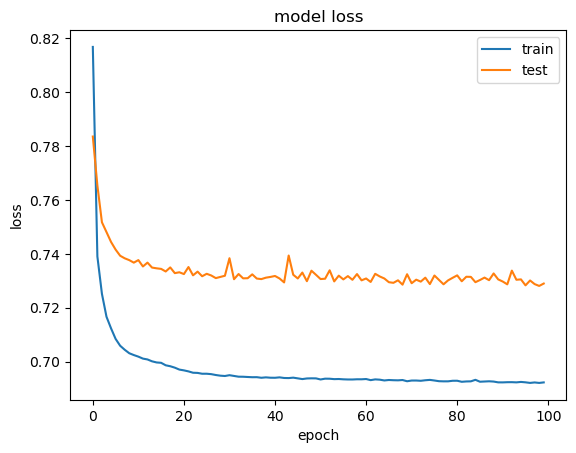

In [7]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');